<a href="https://colab.research.google.com/github/reachusama/product-review-analysis/blob/main/Personal_Python_Notebooks_and_Scripting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Usama Shahid**
---


```
1: Explore the dataset
2: Generate embeddings for textual reviews using OpenAI (Babbage engine) & Sentence Transformers.
3: Label Reviews's Valence & Arousal
  -- Prompt engineering using GPT3's Davnci engine
  -- Label the dataset for Valence & Arousal using designed prompts with GPT3
4: Use ML models to build classifiers for Valence & Arousal.
  -- Used OpenAI's embeddings and labels generated via prompt engineering as input & output sets.
5: Once Valence & Arousal quadrants specified, picked reviews and performed fast clustering using GPT3's embeddings.
6: Use GPT3's Prompt Engieering to explain each cluster based on sample of reviews.
```

```
All Datasets Import & Exports:

https://drive.google.com/drive/folders/1lCXtBDIzX16p6OapdZpoC5Z545DkHeSJ?usp=sharing
```

In [141]:
!pip install pandas
!pip install numpy
!pip install openai
!pip install retry
!pip install -U sentence-transformers
!pip install transformers
!pip install sklearn
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
# Loading, exploring and manipulating datasets
import pandas as pd
import numpy as np
import random
from google.colab import drive

# Error Handling for API calling and importing API keys from envirnoment.
from retry import retry
import time
from time import sleep
import os

# Using gpt3 completions, embeddings and generating multiclass precion-recall
import openai
from openai.embeddings_utils import plot_multiclass_precision_recall

# For tokeizing text to perform validation for GPT3
from transformers import GPT2TokenizerFast

# ML models for classifiers, dimensionality reduction, model analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# For fast clustering and embeddings
from sentence_transformers import SentenceTransformer, util
import torch

# Visualisation
import matplotlib.pyplot as plt
import matplotlib

# Model exports & imports
import pickle

In [143]:
# contants for setting base_path for each user to switch easily.
BASE_PATH = "/content/drive/MyDrive/Product Reviews/Dataset"
RETRY_COUNT = 5
SLEEP_THRESHOLD = 3
openai.api_key = os.getenv("OPENAI_API_KEY")

In [144]:
# Mounting Google Drive for Fetching Datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Exploration
---
**Author: Usama Shahid**



In [ ]:
df = pd.read_json(f"{BASE_PATH}/chunk_1.json")

In [ ]:
df.head()

,review_id,review_header,review_text,author_name,review_asin,author_link,author_id,rating,review_posted_date,review_posted_date_f,is_verified,badge,reviews_count,brand,asin,warning
0,R4I8PJ9FR0GF3,FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL ...,If I could give this a ZERO RATING I would!! I...,mrslokuntry,B0822KNQKT,/gp/profile/amzn1.account.AGXQQFG2AR4GEFCG66Q4...,AGXQQFG2AR4GEFCG66Q4VXBIW22A,1.0,"November 17, 2020",2020-11-17T00:00:00.000Z,1.0,Verified Purchase,107.0,Chef's Path,B0822KNQKT,NaN
1,R1KHEH6D35PXM,"Weird, acrid chemical smell in the lids.",I was looking forward to using these container...,Ruthulhu,B0822KNQKT,/gp/profile/amzn1.account.AHXI6HJME6CETZ3YD2B4...,AHXI6HJME6CETZ3YD2B4CQMJNT5A,1.0,"September 25, 2020",2020-09-25T00:00:00.000Z,1.0,Verified Purchase,107.0,Chef's Path,B0822KNQKT,NaN
2,R35MGJ0HDCABLM,Buyer Beware- NOTHING like the picture,*BUYER BEWARE * NOTHING. LIKE. THE. PICTURE. I...,Melvin,B0822KNQKT,/gp/profile/amzn1.account.AE5N76YYXL6AZ6PHSAKO...,AE5N76YYXL6AZ6PHSAKO7JEHYATQ,1.0,"January 10, 2021",2021-01-10T00:00:00.000Z,1.0,Verified Purchase,107.0,Chef's Path,B0822KNQKT,NaN
3,RK4HRLNJWC7MT,This is what I get for being busy,I have been busy mom and not able to shop in s...,sara,B0822KNQKT,/gp/profile/amzn1.account.AG75BU26YPWSV2VYH3OC...,AG75BU26YPWSV2VYH3OCSOAXBS7A,1.0,"February 13, 2021",2021-02-13T00:00:00.000Z,1.0,Verified Purchase,107.0,Chef's Path,B0822KNQKT,NaN
4,RWGBX6LYL6KXK,TOO SMALL!!,I’m not quite sure why I thought these contain...,Tiffany Siess,B0822KNQKT,/gp/profile/amzn1.account.AER56RPU2HDRG7D7AKQ5...,AER56RPU2HDRG7D7AKQ5JYATNK5A,1.0,"November 16, 2020",2020-11-16T00:00:00.000Z,1.0,Verified Purchase,107.0,Chef's Path,B0822KNQKT,NaN


In [ ]:
df.tail()

,review_id,review_header,review_text,author_name,review_asin,author_link,author_id,rating,review_posted_date,review_posted_date_f,is_verified,badge,reviews_count,brand,asin,warning
99995,R2PVJ8KELJPCAO,7 piece outdoor sectional,Nice set,AK,B09DNYFFVG,/gp/profile/amzn1.account.AF77M5MTAQBQ7KYXTF5Q...,AF77M5MTAQBQ7KYXTF5QNJ63CLOQ,5.0,"October 24, 2020",2020-10-24T00:00:00.000Z,1.0,Verified Purchase,11.0,Gotland,B09DNYFFVG,NaN
99996,R1AEYH2QOLCQHH,Awesome furniture,Great patio furniture set. Great communication...,Amazon Customer,B09DNYFFVG,/gp/profile/amzn1.account.AHHEW37CDVM5ZUFNNUUA...,AHHEW37CDVM5ZUFNNUUAGCKYODXQ,5.0,"February 23, 2021",2021-02-23T00:00:00.000Z,1.0,Verified Purchase,11.0,Gotland,B09DNYFFVG,NaN
99997,RBVTUGVC8B4LA,Love our outdoor sofa!,I had been looking for an outdoor sofa for qui...,Peggy Jackson,B09DNYFFVG,/gp/profile/amzn1.account.AFGRRGOMXK6Q3LWZA7S2...,AFGRRGOMXK6Q3LWZA7S2QN5JAE7A,5.0,"August 18, 2020",2020-08-18T00:00:00.000Z,0.0,,11.0,Gotland,B09DNYFFVG,NaN
99998,RUURQ2WAM7RH,Very strong rubber odor,"Very strong rubber odor, I have left the knock...",Kurt,B07BDK71TR,/gp/profile/amzn1.account.AGZU2UOA4BCV5DHYRRTC...,AGZU2UOA4BCV5DHYRRTCFIQIDP2A,1.0,"August 28, 2019",2019-08-28T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN
99999,R21IHDS0F74O90,Product won’t last long. Already falling apart,I have not had this very long at all and alrea...,Connie Trinkle,B07BDK71TR,/gp/profile/amzn1.account.AFTD2XCTEHJNUJMVPUWP...,AFTD2XCTEHJNUJMVPUWPNPDQ35GA,1.0,"August 21, 2020",2020-08-21T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN


In [ ]:
df.shape

(100000, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_id             99100 non-null  object 
 1   review_header         99100 non-null  object 
 2   review_text           99100 non-null  object 
 3   author_name           99100 non-null  object 
 4   review_asin           99100 non-null  object 
 5   author_link           99100 non-null  object 
 6   author_id             99100 non-null  object 
 7   rating                99100 non-null  float64
 8   review_posted_date    99100 non-null  object 
 9   review_posted_date_f  99100 non-null  object 
 10  is_verified           99100 non-null  float64
 11  badge                 99100 non-null  object 
 12  reviews_count         99100 non-null  float64
 13  brand                 99023 non-null  object 
 14  asin                  99100 non-null  object 
 15  warning           

In [ ]:
df.describe(include='all')

,review_id,review_header,review_text,author_name,review_asin,author_link,author_id,rating,review_posted_date,review_posted_date_f,is_verified,badge,reviews_count,brand,asin,warning
count,99100,99100,99100,99100,99100,99100,99100,99100.000000,99100,99100,99100.000000,99100,99100.000000,99023,99100,900
unique,84259,65645,83010,61057,3456,78854,78854,NaN,2990,2990,NaN,2,NaN,173,2145,1
top,R1THWVAXH96IAF,Five Stars,Good,Amazon Customer,B07PF8NV7N,,,NaN,"June 29, 2021",2021-06-29T00:00:00.000Z,NaN,Verified Purchase,NaN,Wildone,B0822KNQKT,"page was crawled, but didn't produce any data"
freq,16,452,137,6086,490,4002,4002,NaN,202,202,NaN,96302,NaN,7154,100,900
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.365409,NaN,NaN,0.971766,NaN,166.590898,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.491036,NaN,NaN,0.165642,NaN,538.540078,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,1.000000,NaN,16.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,1.000000,NaN,38.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,1.000000,NaN,110.000000,NaN,NaN,NaN


In [ ]:
df = df[["review_id", "review_header", "review_text", "rating", "review_posted_date", "is_verified", "reviews_count", "brand"]]

In [ ]:
df.head()

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand
0,R4I8PJ9FR0GF3,FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL ...,If I could give this a ZERO RATING I would!! I...,1.0,"November 17, 2020",1.0,107.0,Chef's Path
1,R1KHEH6D35PXM,"Weird, acrid chemical smell in the lids.",I was looking forward to using these container...,1.0,"September 25, 2020",1.0,107.0,Chef's Path
2,R35MGJ0HDCABLM,Buyer Beware- NOTHING like the picture,*BUYER BEWARE * NOTHING. LIKE. THE. PICTURE. I...,1.0,"January 10, 2021",1.0,107.0,Chef's Path
3,RK4HRLNJWC7MT,This is what I get for being busy,I have been busy mom and not able to shop in s...,1.0,"February 13, 2021",1.0,107.0,Chef's Path
4,RWGBX6LYL6KXK,TOO SMALL!!,I’m not quite sure why I thought these contain...,1.0,"November 16, 2020",1.0,107.0,Chef's Path


In [ ]:
df["brand"].unique()

array(["Chef's Path", 'fullstar', 'Fullstar', 'OXO', 'Utopia Home',
       'Vtopmart', 'Wildone', 'NATURELO', 'Ultrean', 'Amazon Renewed',
       'Englander', 'Ensenior', 'ComfiLife', 'Live Conscious',
       'Ebanel Laboratories', 'Wisteria Lane', 'tobeDRI',
       'Totally Kitchen', 'Hidrate Spark', 'Coffee Gator', 'TookMag',
       'PhysioNatural', 'House Ur Home', 'ORDORA', 'Ola Prima',
       'TheraGun', 'InteVision', 'oaskys', 'SpriteGru', "Rockin' Green",
       'Everlasting Comfort', 'Incredible Bulk', 'Utopia Kitchen',
       'PECULA', 'BUG BITE THING', 'Homey Pet', "will's", 'EdenProducts',
       'DAYBETTER', '', 'Nieifi', 'Biling', 'Scriveiner',
       'Circadian Optics', 'Cotton Paradise', 'ONNAIS', 'Monument Grills',
       'CrystalTowels', 'Weigh Gram', 'SMARTRO', '500Labels', '1 Body',
       'COVAX', 'Pupford', 'ODesign', 'Sifely', 'MERRYBOX', 'KAC',
       'Annova', 'GOOD LIFE USA', 'Good Life USA', 'POWEROWL',
       'Home Intuition', 'SODUKU', 'Homestead Choice', 'B

In [ ]:
df['brand'].value_counts()

Wildone               2865
Utopia Kitchen        2347
OXO                   2250
SIGNORA WARE          2194
Vtopmart              2013
                      ... 
Fullstar                38
BLACKSMITH FAMILY       30
Vriksasana Posture      10
elv                      8
Gaggle                   3
Name: brand, Length: 173, dtype: int64

In [ ]:
df.drop_duplicates(subset=['review_header', 'review_text'], inplace=True)

In [ ]:
df.shape

(83926, 8)

In [ ]:
df.dropna(subset=['review_header', 'review_text'], inplace=True)

In [ ]:
df.shape

(83926, 8)

In [ ]:
df['brand'].value_counts()

Wildone               2865
Utopia Kitchen        2347
OXO                   2250
SIGNORA WARE          2194
Vtopmart              2013
                      ... 
Fullstar                38
BLACKSMITH FAMILY       30
Vriksasana Posture      10
elv                      8
Gaggle                   3
Name: brand, Length: 173, dtype: int64

In [ ]:
df.to_csv(f"{BASE_PATH}/chunk_1_preprocessed.csv", index=None)

# Common Functions
---
**Author: Usama Shahid**



In [145]:
def read_and_preprocess_dataset(file_path: str="", 
                                is_csv: bool=True,
                                cleanse_dataset: bool=True,
                                transform_columns: bool=True,
                                cols:list=["review_id", 
                                           "review_header", 
                                           "review_text", 
                                           "rating", 
                                           "review_posted_date", 
                                           "is_verified", 
                                           "reviews_count", 
                                           "brand"]
                                ):
  
  try:
    df = pd.read_csv(file_path) if is_csv else pd.read_json(file_path)

    if cleanse_dataset:
      df.drop_duplicates(subset=["review_header", "review_text"], 
                         inplace=True)
      df.dropna(subset=["review_header", "review_text"], 
                inplace=True)
    
    if transform_columns:
      df = df[cols]

    return df
  except Exception as e:
    print(f"Exception(read_and_preprocess_dataset): ", e)
    return None

In [146]:
def get_tokenized_string(text: str):
  tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
  return tokenizer.encode(text)

In [147]:
def balance_dataset_based_on_categories(df, target_column="valence", category_values=[]):
  try:
    dataframes = []
    for category in category_values:
      dummy = df.loc[df[target_column] == category]
      dataframes.append(dummy)

    lengths = [len(frame) for frame in dataframes]
    max_length = min(lengths)
    resized_dataframes = []

    for i, frame in enumerate(dataframes):
      dataframes[i] = dataframes[i][:max_length]

    return pd.concat(dataframes)

  except Exception as e:
    return f"Error(balance_dataset_based_on_categories): {e}"

# Generating Embeddings
---

**Author: Usama Shahid**



## Sentence Transformers Embeddings

**References:**
* https://www.sbert.net/examples/applications/computing-embeddings/README.html

In [ ]:
df = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_1_preprocessed.csv")

In [ ]:
df.head(1)

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand
0,R4I8PJ9FR0GF3,FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL ...,If I could give this a ZERO RATING I would!! I...,1.0,"November 17, 2020",1.0,107.0,Chef's Path


In [ ]:
df.shape

(83861, 8)

In [ ]:
df['combined'] = "Title: " + df.review_header.str.strip() + "; Content: " + df.review_text.str.strip()

In [ ]:
df.head()

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand,combined
0,R4I8PJ9FR0GF3,FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL ...,If I could give this a ZERO RATING I would!! I...,1.0,"November 17, 2020",1.0,107.0,Chef's Path,Title: FALSE ADVERTISING!!!!!! NOT AS ADVERISE...
1,R1KHEH6D35PXM,"Weird, acrid chemical smell in the lids.",I was looking forward to using these container...,1.0,"September 25, 2020",1.0,107.0,Chef's Path,"Title: Weird, acrid chemical smell in the lids..."
2,R35MGJ0HDCABLM,Buyer Beware- NOTHING like the picture,*BUYER BEWARE * NOTHING. LIKE. THE. PICTURE. I...,1.0,"January 10, 2021",1.0,107.0,Chef's Path,Title: Buyer Beware- NOTHING like the picture;...
3,RK4HRLNJWC7MT,This is what I get for being busy,I have been busy mom and not able to shop in s...,1.0,"February 13, 2021",1.0,107.0,Chef's Path,Title: This is what I get for being busy; Cont...
4,RWGBX6LYL6KXK,TOO SMALL!!,I’m not quite sure why I thought these contain...,1.0,"November 16, 2020",1.0,107.0,Chef's Path,Title: TOO SMALL!!; Content: I’m not quite sur...


In [ ]:
STE_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
STE_embeddings = STE_model.encode(df.combined.values, convert_to_tensor=False)

In [ ]:
for sentence, embedding in zip(df.combined.values, STE_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    break

Sentence: Title: FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL SMALL CONTAINERS!!!; Content: If I could give this a ZERO RATING I would!! I bought these because they had more good reviews than bad. I should have listened to the BAD reviewers! I finally got around to cleaning my pantry and was excited to use these. Unfortunately, These are ALL SMALL containers! SEE PHOTO OF PASTA IN CONTATINER! How am I supposed to get the lid on without breaking up the pasta? NOW I'M OUT $45 BECAUSE THEY CAN'T BE RETURNED!!!!! They are hard to close and some won't close all the way and they smell!! I guess that's why they have a no return policy. I will do as my husband told me next time I order from Amazon," Make sure that you can return it before you purchase." DON'T BUY THESE, YOU CAN GET SOME FROM THE DOLLAR STORE FOR LESS!!!!!
Embedding: [-5.3986e-03,  6.6709e-03,  1.4786e-02,  6.8348e-02,  8.8113e-02,
        -5.2730e-02,  5.7512e-02, -6.2546e-02,  2.4495e-02, -7.8612e-02,
         6.1970e-02,  1

In [ ]:
df["STE_embeddings"] = ""

In [ ]:
for index, embedding in enumerate(df.STE_embeddings.values):
    df["STE_embeddings"].iloc[index] = embedding
    print(index, len(embedding))

In [ ]:
df.head()

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand,combined,STE_embeddings
0,R4I8PJ9FR0GF3,FALSE ADVERTISING!!!!!! NOT AS ADVERISED! ALL ...,If I could give this a ZERO RATING I would!! I...,1.0,"November 17, 2020",1.0,107.0,Chef's Path,Title: FALSE ADVERTISING!!!!!! NOT AS ADVERISE...,"[-5.3986e-03, 6.6709e-03, 1.4786e-02, 6.834..."
1,R1KHEH6D35PXM,"Weird, acrid chemical smell in the lids.",I was looking forward to using these container...,1.0,"September 25, 2020",1.0,107.0,Chef's Path,"Title: Weird, acrid chemical smell in the lids...","[ 6.6079e-02, -4.7454e-02, 5.3329e-02, 3.106..."
2,R35MGJ0HDCABLM,Buyer Beware- NOTHING like the picture,*BUYER BEWARE * NOTHING. LIKE. THE. PICTURE. I...,1.0,"January 10, 2021",1.0,107.0,Chef's Path,Title: Buyer Beware- NOTHING like the picture;...,"[-5.3846e-02, 1.0647e-01, 8.3936e-04, 2.314..."
3,RK4HRLNJWC7MT,This is what I get for being busy,I have been busy mom and not able to shop in s...,1.0,"February 13, 2021",1.0,107.0,Chef's Path,Title: This is what I get for being busy; Cont...,"[-5.8914e-02, 9.8236e-03, 3.6367e-02, 5.050..."
4,RWGBX6LYL6KXK,TOO SMALL!!,I’m not quite sure why I thought these contain...,1.0,"November 16, 2020",1.0,107.0,Chef's Path,Title: TOO SMALL!!; Content: I’m not quite sur...,"[ 3.4800e-02, 3.8797e-02, 1.0047e-02, -5.306..."


In [ ]:
df.to_csv(f"{BASE_PATH}/chunk_1_STE_embeddings.csv", index=None)

## OpenAI Embeddings - Babbage

**References:**

* https://beta.openai.com/docs/guides/embeddings/what-are-embeddings

In [ ]:
df = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2.json", is_csv=False)

In [ ]:
df.head()

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand
0,R176WUN6YB5Y2J,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",1.0,"March 19, 2021",1.0,8.0,Apexstone
1,RWSJHY80TLLZW,SMELLS awful,has that horrible harbor freight VOC smell.. f...,1.0,"May 16, 2020",1.0,8.0,Apexstone
2,R2NPVTFY0ZRCK9,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,1.0,"August 25, 2021",1.0,8.0,Apexstone
3,RURFK88JSDXAD,"Knock Knock, broken",After 1 month it falls apart,1.0,"May 6, 2020",1.0,8.0,Apexstone
4,R28R3CJZSSCRM7,Smelled like burning rubber,Looks great but stunk up my entire house even ...,1.0,"November 8, 2021",1.0,8.0,Apexstone


In [ ]:
df.shape

(97687, 8)

In [ ]:
df = df.loc[:25000]

In [ ]:
df.shape

(24360, 8)

In [ ]:
df['combined'] = "Title: " + df.review_header.str.strip() + "; Content: " + df.review_text.str.strip()

In [ ]:
df["n_tokens"] = df.combined.apply(lambda x: get_tokenized_string(x))

In [ ]:
df = df[df.n_tokens<2000]

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
def get_openai_embeddings(model: str = "text-similarity-babbage-001", input: str = ""):
  for i in range(RETRY_COUNT):
    try:
      embeddings = openai.Embedding.create(
        model=model,
        input=input
      )
      return embeddings["data"][0]["embedding"]
    except Exception as e:
      print(f"Error(get_openai_embeddings): ", e)
      sleep(SLEEP_THRESHOLD)

In [ ]:
get_openai_embeddings(input="HELLO !")

[0.012614703737199306,
 -0.016512639820575714,
 0.013773763552308083,
 -0.014385049231350422,
 0.0084944823756814,
 -0.0020958350505679846,
 -0.006247811019420624,
 0.003612139727920294,
 0.006581239402294159,
 -0.05068109929561615,
 0.0020462176762521267,
 0.043726738542318344,
 0.029675116762518883,
 0.013757886365056038,
 0.01527419127523899,
 0.000374858733266592,
 0.01978341117501259,
 -0.02776981331408024,
 -0.00044357869774103165,
 0.03480356186628342,
 0.12524200975894928,
 0.001280126511119306,
 -0.017751086503267288,
 -0.026039160788059235,
 -0.007637095637619495,
 -0.01299576461315155,
 -0.03648658096790314,
 0.022387327626347542,
 -0.019989820197224617,
 -0.02157757431268692,
 0.027436384931206703,
 0.016941333189606667,
 0.02567397803068161,
 -0.008923175744712353,
 -0.015051905997097492,
 -0.006299412809312344,
 0.02721409872174263,
 -0.042329516261816025,
 0.0019688147585839033,
 -0.023371735587716103,
 -0.008589747361838818,
 0.0064343721605837345,
 0.03597849979996681,

In [ ]:
df["babbage_similarity"] = df.combined.apply(lambda x: get_openai_embeddings(x))

In [ ]:
df.head()

,review_id,review_header,review_text,rating,review_posted_date,is_verified,reviews_count,brand,combined,n_tokens,babbage_similarity
0,R176WUN6YB5Y2J,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",1.0,"March 19, 2021",1.0,8.0,Apexstone,"Title: Stinky, sloppy cut hose.; Content: It w...",78.0,"[0.00666764285415411, 0.022180898115038872, -0..."
1,RWSJHY80TLLZW,SMELLS awful,has that horrible harbor freight VOC smell.. f...,1.0,"May 16, 2020",1.0,8.0,Apexstone,Title: SMELLS awful; Content: has that horribl...,34.0,"[0.002960040932521224, 0.011734704487025738, -..."
2,R2NPVTFY0ZRCK9,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,1.0,"August 25, 2021",1.0,8.0,Apexstone,Title: Terrible Rubber Smell; Content: Thought...,53.0,"[0.02114497497677803, 0.016543280333280563, -0..."
3,RURFK88JSDXAD,"Knock Knock, broken",After 1 month it falls apart,1.0,"May 6, 2020",1.0,8.0,Apexstone,"Title: Knock Knock, broken; Content: After 1 m...",15.0,"[0.006736414507031441, 0.015398834832012653, -..."
4,R28R3CJZSSCRM7,Smelled like burning rubber,Looks great but stunk up my entire house even ...,1.0,"November 8, 2021",1.0,8.0,Apexstone,Title: Smelled like burning rubber; Content: L...,29.0,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df.shape

(25001, 11)

In [ ]:
df.to_csv(f"{BASE_PATH}/chunk_2_Openai_babbage_embeddings.csv", index=None)

# Valence & Arousal 
---
**Author: Usama Shahid**
```
The goal is to combine topic clusters with two dimensions of emotions (Arousal and Valence)

Emotions are distributed in a two-dimensional circular space, containing arousal and valence dimensions.

Arousal represents the vertical axis and valence represents the horizontal axis, 
while the center of the circle represents a neutral valence and a medium level of arousal.

- Valence (is the review written in a positive or negative mood/style)
- Arousal (from Calm - Exited)
- Context (Service-Specific → Product-Specific) OR Topics 
```


![Valence and Arousal](https://drive.google.com/uc?export=view&id=1chWRWB9kg7C_6N_czxLJztSh0VHWI7UX)



In [ ]:
combinations= {
    "happy": {"arousal": "high", "valence": "positive"},
    "relaxed": {"arousal": "low", "valence": "positive"},
    "sad": {"arousal": "low", "valence": "negative"},
    "angry": {"arousal": "high", "valence": "negative"},
}

In [ ]:
class OpenAI:
  @retry(exceptions=Exception, tries=RETRY_COUNT, delay=SLEEP_THRESHOLD)
  def get_completion(self, 
                     model: str = "text-davinci-003",
                     prompt: str = "",
                     temperature: float = 0.7,
                     max_tokens: int = 1000,
                     top_p: int = 1,
                     frequency_penalty: float = 0,
                     presence_penalty: float = 0):
    try:
      response = openai.Completion.create(
        model=model,
        prompt=prompt,
        temperature=temperature,
        max_tokens=max_tokens,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty
      )

      return str(response["choices"][0]["text"]).strip()

    except Exception as e:
      print(f"Error(OpenAI: get_commpletion): ", e)
      

  
  def get_valence_labelling_prompt(self, 
                                   review_text: str, 
                                   review_header: str):
    
    st = "Decide based on Review Header and Review Text whether the Review's"
    st += " Valence is positive, neutral, or negative."
    st += f"\nReview Header: {review_text}"
    st += f"\nReview Text: {review_text}"
    st += "\nValence:"

    return st

  def get_arousal_labelling_prompt(self, 
                                   review_text: str, 
                                   review_header: str):
    st = "Decide based on Review Header and Review Text whether the Review's"
    st += " Arousal is positive, neutral, or negative."
    st += f"\nReview Header: {review_text}"
    st += f"\nReview Text: {review_text}"
    st += "\nArousal:"

    return st

  def get_context_analysis_prompt(self, 
                                   review_text: str, 
                                   review_header: str):
    pass

In [ ]:
class Model:
  def __init__(self,
               is_model_loading: bool=False,
               model_name: str="", 
               input_data: list=[], 
               output: list=[], 
               labels:list=[]):
    
    if not is_model_loading:
      if len(model_name) == 0 or len(input_data) == 0 or len(output) == 0:
        raise Exception("Model: Invalid Initialization")

    self.models = ["classifier", "svc"]
    self.model_name = model_name
    self.input_data = input_data
    self.output = output
    self.labels = labels

  def split_data(self, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        self.input_data, 
        self.output, 
        test_size=test_size, 
        random_state=42
    )
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test    

  def train(self, **kwargs):
    if self.model_name in self.models:
      start_time = time.time()

      if self.model_name == "classifier":
        self.model = RandomForestClassifier(**kwargs)
        self.model.fit(self.X_train, self.y_train)

      elif self.model_name == "svc":
        self.model = SVC(kernel = 'linear', C = 1, **kwargs)
        self.model.fit(self.X_train, self.y_train)
      
      end_time = round(time.time() - start_time, 2)
      print(f"{self.model_name.upper()} Model Training Done after {end_time} sec")

    else:
      return "Invalid Model"

  def predict(self, input=[]):
    if len(input) > 0:
      return self.model.predict(input)      
    self.preds = self.model.predict(self.X_test)

  def report(self):
    return classification_report(self.y_test, self.preds)

  
  def plot_precision_recall(self):
    self.probas = self.model.predict_proba(self.X_test)
    plot_multiclass_precision_recall(self.probas, 
                                     self.y_test, 
                                     self.labels, 
                                     self.model)
  
  def save_model(self, file_name):
    pickle.dump(self.model, open(file_name, 'wb'))
 
  def load_model(self, file_name):
    self.model = pickle.load(open(file_name, 'rb'))

## Analysing embeddings

## Generating Valence and Arousal Datasets


In [ ]:
ob_openai = OpenAI()

### Valence Processing

In [ ]:
df_valence = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2.json",
                                          is_csv=False,
                                          cols=["review_header", 
                                                "review_text"],
                                         )

In [ ]:
df_valence.head()

,review_header,review_text
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...
3,"Knock Knock, broken",After 1 month it falls apart
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...


In [ ]:
df_valence.shape

(95953, 2)

In [ ]:
df_valence["valence"] = ""

In [ ]:
df_valence.head()

,review_header,review_text,valence
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,
3,"Knock Knock, broken",After 1 month it falls apart,
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,


In [ ]:
def get_valence_label(row):
  row = dict(row)
  prompt = ob_openai.get_valence_labelling_prompt(row["review_text"], row["review_header"])
  return ob_openai.get_completion(prompt=prompt, 
                                  temperature=0.8, 
                                  frequency_penalty=2, 
                                  presence_penalty=0) 

In [ ]:
df_valence["valence"] = df_valence.apply(lambda row: get_valence_label(row))

In [ ]:
df_valence.head()

,review_header,review_text,valence
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative
3,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative
4,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative
5,"Knock Knock, broken",After 1 month it falls apart,negative
6,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative


In [ ]:
df_valence.to_csv(f"{BASE_PATH}/chunk_2_valence_labeled.csv", index=False)

### Arousal Processing

In [ ]:
df_arousal = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2.json",
                                         is_csv=False,
                                         cols=["review_header", 
                                                "review_text"])

In [ ]:
df_arousal.head()

,review_header,review_text
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...
3,"Knock Knock, broken",After 1 month it falls apart
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...


In [ ]:
df_arousal.shape

(95953, 7)

In [ ]:
def get_arousal_label(row):

  row = dict(row)
  prompt = ob_openai.get_arousal_labelling_prompt(row["review_text"], row["review_header"])
  return ob_openai.get_completion(prompt=prompt, 
                                  temperature=0.8, 
                                  frequency_penalty=2, 
                                  presence_penalty=0) 

In [ ]:
df_arousal["arousal"] = df_arousal.apply(lambda row: get_arousal_label(row))

In [ ]:
df_arousal.head()

,review_header,review_text,arousal
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low
3,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high
4,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low
5,"Knock Knock, broken",After 1 month it falls apart,low
6,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high


In [ ]:
df_arousal.to_csv(f"{BASE_PATH}/chunk_2_arousal_labeled.csv", index=False)

## Pre-processing Datasets for Valence & Arousal

### Valence Processing

In [ ]:
df_valence = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_valence_labeled.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_valence.head()

,review_header,review_text,valence
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative
3,"Knock Knock, broken",After 1 month it falls apart,negative
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative


In [ ]:
df_valence.shape

(95953, 3)

In [ ]:
df_valence.valence.nunique()

101

In [ ]:
df_valence.valence.unique()

array(['negative', 'neutral', 'positive', 'good', 'good value',
       'good enough before it falls apart',
       'the valence is negative because the product does not help my dog and her discomfort.',
       'the valence is positive because the product worked for one person and did not work for another.',
       'the valence is positive because the brush is good for other self cleaning brushes.',
       'the valence of this review is positive.',
       'the valence is positive because the set of supports seems to keep the lid from slamming shut.',
       'the text is positive, as the two items are different and have a different use.',
       'the valence is negative because the company does not improve the lid open time of the strut.',
       'the text is negative.', 'the valence of this review is neutral.',
       '5 stars',
       "the valence is positive because the review is positive about the product's performance.",
       'the valence of a gas spring is positive.',
       'the

In [ ]:
legal_columns = ['negative', 'neutral', 'positive']

In [ ]:
df_valence = df_valence[df_valence["valence"].isin(legal_columns)]

In [ ]:
df_valence.valence.unique(), df_valence.valence.nunique()

(array(['negative', 'neutral', 'positive'], dtype=object), 3)

In [ ]:
df_valence["valence"].value_counts()

positive    42605
neutral     30173
negative    13865
Name: valence, dtype: int64

In [ ]:
df_valence.shape

(86643, 3)

In [ ]:
df_valence.to_csv(f"{BASE_PATH}/chunk_2_valence_ready.csv", index=False)

### Arousal Processing

In [ ]:
df_arousal = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_arousal_labeled.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_arousal.head()

,review_header,review_text,arousal
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low
3,"Knock Knock, broken",After 1 month it falls apart,low
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high


In [ ]:
df_arousal.shape

(95953, 3)

In [ ]:
df_arousal.arousal.nunique()

349

In [ ]:
df_arousal.arousal.unique()

array(['low', 'high', 'good', 'good for', 'good value', '3',
       'three stars', 'neutral', 'good product', 'near perfect', 'great',
       'good item', '5', 'good in', 'good pressure', 'good deal',
       'good overall', nan, '3 stars', 'good practice', '3/',
       'low quality', '4', '4/', 'medium to', 'good price', '2.',
       'good quality', 'average', 'good stuff', 'medium', 'good purchase',
       'good buy', 'great for', 'excellent', 'goodvalue', 'fine', '4 out',
       '4.', 'arous', 'new product', 'good pet', 'good dog', 'best',
       'good grip', 'good basic', 'mostly satisfied', 'good priced',
       'good weight', 'five stars', 'good one', '1', 'better than',
       '2 star', '6', 'good enough', 'great but', '10', 'unknown at',
       'better quality', '60"', 'good looking', '7', 'good fit',
       'good screen', 'great alternative', 'good idea', 'good mount',
       'great stuff', 'good light', 'good mix', 'good sun', 'good budget',
       'light', 'good but', 'no', '

In [ ]:
legal_columns = ['low', 'neutral', 'high']

In [ ]:
df_arousal = df_arousal[df_arousal["arousal"].isin(legal_columns)]

In [ ]:
df_arousal.arousal.unique(), df_arousal.arousal.nunique()

(array(['low', 'high', 'neutral'], dtype=object), 3)

In [ ]:
df_arousal["arousal"].value_counts()

high       65225
low        25989
neutral      677
Name: arousal, dtype: int64

In [ ]:
df_arousal.shape

(91891, 3)

In [ ]:
df_arousal.to_csv(f"{BASE_PATH}/chunk_2_arousal_ready.csv", index=False)

## Merge of Valence & Arousal Dataset with OpenAI Embeddings

### Valence Merge

In [ ]:
df_valence = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_valence_ready.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_openai_embeddings = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_Openai_babbage_embeddings.csv",
                                          cols=["review_header", "review_text", "combined" ,"babbage_similarity"],
                                          cleanse_dataset=False)

In [ ]:
df_valence.head()

,review_header,review_text,valence
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative
3,"Knock Knock, broken",After 1 month it falls apart,negative
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative


In [ ]:
df_openai_embeddings.head()

,review_header,review_text,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...","Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_valence_merged = pd.merge(df_valence, 
                             df_openai_embeddings,  
                             on=['review_header','review_text'])

In [ ]:
df_valence_merged.head()

,review_header,review_text,valence,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,negative,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_valence_merged[df_valence_merged.isna().any(axis=1)]

,review_header,review_text,valence,combined,babbage_similarity


In [ ]:
df_valence_merged.shape

(18553, 5)

In [ ]:
df_valence_merged.to_csv(f"{BASE_PATH}/chunk_2_valence_w_embeddings.csv", index=False)

### Arousal Merge

In [ ]:
df_arousal = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_arousal_ready.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_openai_embeddings = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_Openai_babbage_embeddings.csv",
                                          cols=["review_header", "review_text", "combined" ,"babbage_similarity"],
                                          cleanse_dataset=False)

In [ ]:
df_arousal.head()

,review_header,review_text,arousal
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low
3,"Knock Knock, broken",After 1 month it falls apart,low
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high


In [ ]:
df_openai_embeddings.head()

,review_header,review_text,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...","Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_arousal_merged = pd.merge(df_arousal, 
                             df_openai_embeddings,  
                             on=['review_header','review_text'])

In [ ]:
df_arousal_merged[df_arousal_merged.isna().any(axis=1)]

,review_header,review_text,arousal,combined,babbage_similarity


In [ ]:
df_arousal_merged.head()

,review_header,review_text,arousal,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,low,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_arousal_merged.shape

(19705, 5)

In [ ]:
df_arousal_merged.to_csv(f"{BASE_PATH}/chunk_2_arousal_w_embeddings.csv", index=False)

## Training Models for Valence & Arousal

### Valence Modelling

In [ ]:
df_valence = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_valence_w_embeddings.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_valence.head()

,review_header,review_text,valence,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,negative,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_valence.shape

(18553, 5)

In [ ]:
df_valence["babbage_similarity"] = df_valence.babbage_similarity.apply(eval).apply(np.array)

In [ ]:
df_valence.valence.value_counts()

positive    9205
neutral     6447
negative    2901
Name: valence, dtype: int64

In [ ]:
df_valence["valence"] = pd.Categorical(df_valence.valence)

In [ ]:
dict(enumerate(df_valence.valence.cat.categories))

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
df_valence['valence_code'] = df_valence.valence.cat.codes

In [ ]:
df_valence.head()

,review_header,review_text,valence,combined,babbage_similarity,valence_code
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",negative,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0...",0
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,negative,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -...",0
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,negative,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0...",0
3,"Knock Knock, broken",After 1 month it falls apart,negative,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -...",0
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,negative,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0...",0


#### Random Forest Classifier

In [ ]:
random_forest_classifier = Model(
    model_name="classifier",
    input_data=list(df_valence.babbage_similarity.values),
    output=df_valence.valence_code,
    labels=list(df_valence.valence.cat.codes.unique())
)

In [ ]:
random_forest_classifier.split_data(test_size=0.2)

In [ ]:
random_forest_classifier.train(n_estimators=100)

In [ ]:
random_forest_classifier.predict()

In [ ]:
print(random_forest_classifier.report())

              precision    recall  f1-score   support

           0       0.72      0.43      0.53       588
           1       0.63      0.68      0.66      1282
           2       0.84      0.90      0.87      1841

    accuracy                           0.75      3711
   macro avg       0.73      0.67      0.69      3711
weighted avg       0.75      0.75      0.74      3711



RandomForestClassifier() - Average precision score over all classes: 0.83


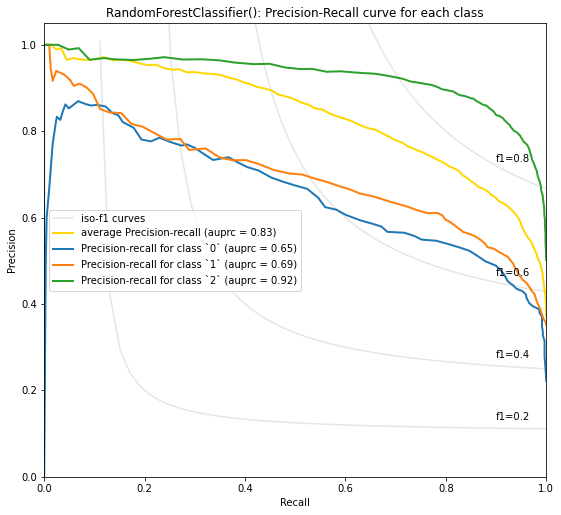

In [ ]:
random_forest_classifier.plot_precision_recall()

#### Random Forest Classifier With Balanced Dataset

In [ ]:
df_valence_balanced = balance_dataset_based_on_categories(df_valence, 
                                        target_column="valence", 
                                        category_values=[
                                            "positive",
                                            "negative",
                                            "neutral"
                                        ])

In [ ]:
df_valence_balanced.valence.value_counts()

negative    2901
neutral     2901
positive    2901
Name: valence, dtype: int64

In [ ]:
random_forest_classifier_B = Model(
    model_name="classifier",
    input_data=list(df_valence_balanced.babbage_similarity.values),
    output=df_valence_balanced.valence_code,
    labels=list(df_valence_balanced.valence.cat.codes.unique())
)

In [ ]:
random_forest_classifier_B.split_data(test_size=0.2)

In [ ]:
random_forest_classifier_B.train(n_estimators=100)

In [ ]:
random_forest_classifier_B.predict()

In [ ]:
print(random_forest_classifier_B.report())

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       286
           1       0.63      0.49      0.55       291
           2       0.82      0.87      0.84       294

    accuracy                           0.72       871
   macro avg       0.71      0.72      0.71       871
weighted avg       0.71      0.72      0.71       871



RandomForestClassifier() - Average precision score over all classes: 0.23


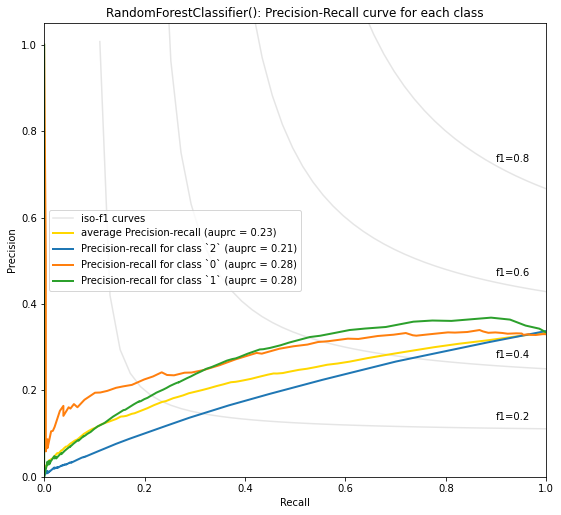

In [ ]:
random_forest_classifier_B.plot_precision_recall()

#### Support Vector Machine

In [ ]:
support_vector_machine = Model(
    model_name="svc",
    input_data=list(df_valence.babbage_similarity.values),
    output=df_valence.valence_code,
    labels=list(df_valence.valence.cat.codes.unique())
)

In [ ]:
support_vector_machine.split_data(test_size=0.2)

In [ ]:
support_vector_machine.train(probability=True)

In [ ]:
support_vector_machine.predict()

In [ ]:
print(support_vector_machine.report())

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       588
           1       0.69      0.69      0.69      1282
           2       0.86      0.91      0.88      1841

    accuracy                           0.78      3711
   macro avg       0.75      0.73      0.74      3711
weighted avg       0.78      0.78      0.78      3711



SVC(C=1, kernel='linear', probability=True) - Average precision score over all classes: 0.88


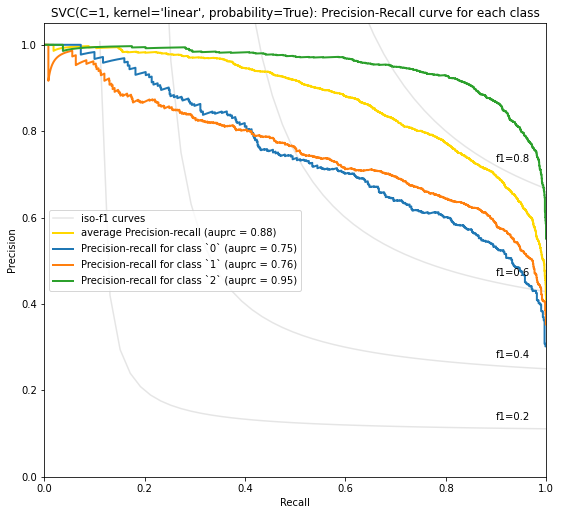

In [ ]:
support_vector_machine.plot_precision_recall()

In [ ]:
support_vector_machine.save_model(f"{BASE_PATH}/valence_svc_classifier.sav")

### Arousal Modelling

In [ ]:
df_arousal = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_arousal_w_embeddings.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df_arousal.head()

,review_header,review_text,arousal,combined,babbage_similarity
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0..."
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -..."
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0..."
3,"Knock Knock, broken",After 1 month it falls apart,low,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -..."
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0..."


In [ ]:
df_arousal.shape

(19705, 5)

In [ ]:
df_arousal["babbage_similarity"] = df_arousal.babbage_similarity.apply(eval).apply(np.array)

In [ ]:
df_arousal.arousal.value_counts()

high       14193
low         5385
neutral      127
Name: arousal, dtype: int64

In [ ]:
df_arousal["arousal"] = pd.Categorical(df_arousal.arousal)

In [ ]:
dict(enumerate(df_arousal.arousal.cat.categories))

{0: 'high', 1: 'low', 2: 'neutral'}

In [ ]:
df_arousal['arousal_code'] = df_arousal.arousal.cat.codes

In [ ]:
df_arousal.head()

,review_header,review_text,arousal,combined,babbage_similarity,arousal_code
0,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",low,"Title: Stinky, sloppy cut hose.; Content: It w...","[0.00666764285415411, 0.022180898115038872, -0...",1
1,SMELLS awful,has that horrible harbor freight VOC smell.. f...,high,Title: SMELLS awful; Content: has that horribl...,"[0.002960040932521224, 0.011734704487025738, -...",0
2,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,low,Title: Terrible Rubber Smell; Content: Thought...,"[0.02114497497677803, 0.016543280333280563, -0...",1
3,"Knock Knock, broken",After 1 month it falls apart,low,"Title: Knock Knock, broken; Content: After 1 m...","[0.006736414507031441, 0.015398834832012653, -...",1
4,Smelled like burning rubber,Looks great but stunk up my entire house even ...,high,Title: Smelled like burning rubber; Content: L...,"[0.012572546489536762, 0.021474963054060936, 0...",0


#### Random Forest Classifier

In [ ]:
random_forest_classifier = Model(
    model_name="classifier",
    input_data=list(df_arousal.babbage_similarity.values),
    output=df_arousal.arousal_code,
    labels=list(df_arousal.arousal.cat.codes.unique())
)

In [ ]:
random_forest_classifier.split_data(test_size=0.2)

In [ ]:
random_forest_classifier.train(n_estimators=100)

CLASSIFIER Model Training Done after 373.48 sec


In [ ]:
random_forest_classifier.predict()

In [ ]:
print(random_forest_classifier.report())

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2834
           1       0.70      0.61      0.65      1074
           2       0.00      0.00      0.00        33

    accuracy                           0.81      3941
   macro avg       0.52      0.50      0.51      3941
weighted avg       0.80      0.81      0.81      3941



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier() - Average precision score over all classes: 0.31


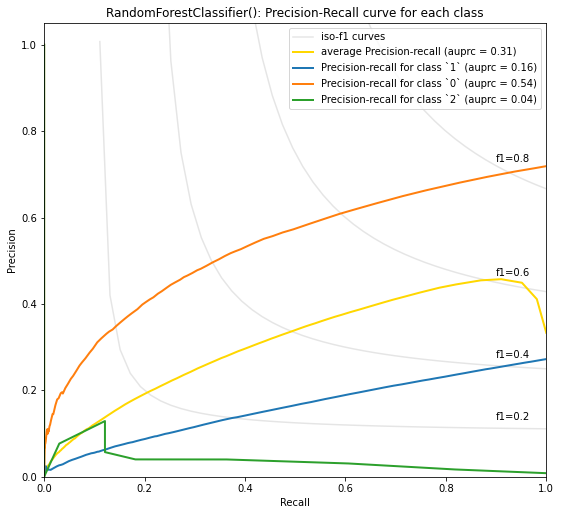

In [ ]:
random_forest_classifier.plot_precision_recall()

#### Random Forest Classifier With Balanced Dataset

In [ ]:
df_arousal_balanced = balance_dataset_based_on_categories(df_arousal, 
                                        target_column="arousal", 
                                        category_values=[
                                            "high",
                                            "low",
                                            "neutral"
                                        ])

In [ ]:
df_arousal_balanced.arousal.value_counts()

high       127
low        127
neutral    127
Name: arousal, dtype: int64

In [ ]:
random_forest_classifier_B = Model(
    model_name="classifier",
    input_data=list(df_arousal_balanced.babbage_similarity.values),
    output=df_arousal_balanced.arousal_code,
    labels=list(df_arousal_balanced.arousal.cat.codes.unique())
)

In [ ]:
random_forest_classifier_B.split_data(test_size=0.2)

In [ ]:
random_forest_classifier_B.train(n_estimators=100)

CLASSIFIER Model Training Done after 1.05 sec


In [ ]:
random_forest_classifier_B.predict()

In [ ]:
print(random_forest_classifier_B.report())

              precision    recall  f1-score   support

           0       0.88      0.65      0.75        34
           1       0.58      0.86      0.69        21
           2       1.00      0.95      0.98        22

    accuracy                           0.79        77
   macro avg       0.82      0.82      0.80        77
weighted avg       0.83      0.79      0.80        77



RandomForestClassifier() - Average precision score over all classes: 0.90


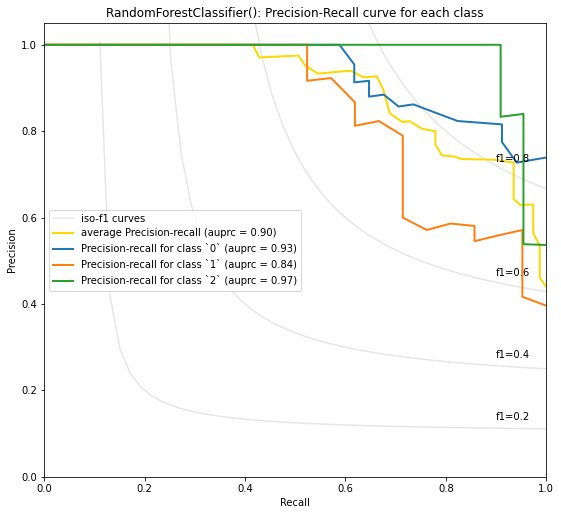

In [ ]:
random_forest_classifier_B.plot_precision_recall()

#### Support Vector Machine

In [ ]:
support_vector_machine = Model(
    model_name="svc",
    input_data=list(df_arousal.babbage_similarity.values),
    output=df_arousal.arousal_code,
    labels=list(df_arousal.arousal.cat.codes.unique())
)

In [ ]:
support_vector_machine.split_data(test_size=0.2)

In [ ]:
support_vector_machine.train(probability=True)

SVC Model Training Done after 2691.13 sec


In [ ]:
support_vector_machine.predict()

In [ ]:
print(support_vector_machine.report())

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2834
           1       0.70      0.69      0.70      1074
           2       0.00      0.00      0.00        33

    accuracy                           0.83      3941
   macro avg       0.53      0.53      0.53      3941
weighted avg       0.82      0.83      0.83      3941



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC(C=1, kernel='linear', probability=True) - Average precision score over all classes: 0.31


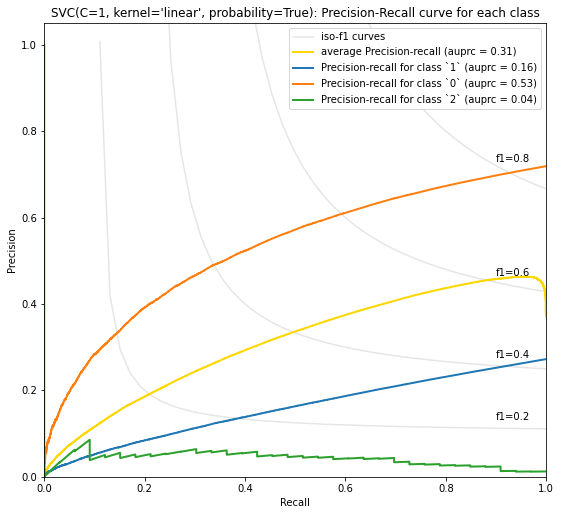

In [ ]:
support_vector_machine.plot_precision_recall()

In [ ]:
support_vector_machine.save_model(f"{BASE_PATH}/arousal_svc_classifier.sav")

# Combining Context Clustering with Valence & Arousal 

```
1: Read dataset with embeddings
2: Pick a brand/service/product reviews
3: Classify Valence & Arousal 
4: Make quadrant groups based on Valence & Arousal
5: Performing Clustering for each quadrant
6: Explaining each cluster using samples with help of GPT3's davinci (Prompt Engineering)
```

## Common Functions

In [ ]:
def get_reduced_embeddings_dimensions(matrix, dimensions=2, **kwargs):
  try:
    tsne = TSNE(n_components=dimensions, perplexity=15, random_state=42, init='random', learning_rate=200, **kwargs)
    vis_dims = tsne.fit_transform(matrix)
    return vis_dims
  except Exception as e:
    print(f"Error(reduce_embeddings_dimensions): {e}")

In [148]:
def fast_cluster_reviews(embeddings, 
                    min_cluster_size:int=25, 
                    probability:float=0.75):
  try:
    return util.community_detection(torch.FloatTensor(embeddings.to_list()), 
                                    min_community_size=min_cluster_size, 
                                    threshold=probability)
  except Exception as e:
    print(f"Error(cluster_reviews): {e}")

In [210]:
def print_fast_clustered_reviews(df_reviews, clusters):
  for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in random.sample(cluster, 3):
        print("\t", 
              "REVIEW HEADER: ", df_reviews.iloc[sentence_id]["review_header"], 
              "| REVIEW TEXT: ", df_reviews.iloc[sentence_id]["review_text"][:70])

In [ ]:
def get_cluster_analysis(clusters):
  rev_per_cluster = 3

  for i in range(n_clusters):
      print(f"Cluster {i} Theme:", end=" ")

      reviews = "\n".join(
          df[df.Cluster == i]
          .combined.str.replace("Title: ", "")
          .str.replace("\n\nContent: ", ":  ")
          .sample(rev_per_cluster, random_state=42)
          .values
      )
      response = openai.Completion.create(
          engine="text-davinci-003",
          prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
          temperature=0,
          max_tokens=64,
          top_p=1,
          frequency_penalty=0,
          presence_penalty=0,
      )
      print(response["choices"][0]["text"].replace("\n", ""))

      sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
      
      for j in range(rev_per_cluster):
          print(sample_cluster_rows.Score.values[j], end=", ")
          print(sample_cluster_rows.Summary.values[j], end=":   ")
          print(sample_cluster_rows.Text.str[:70].values[j])

      print("-" * 100)

In [222]:
def get_random_colors(n=3):
  colrs = []
  for i in range(n):
    color = "#"+ ''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    colrs.append(color)
  return colrs

In [277]:
def plot_embeddings(vis_dims, 
                    title: str = "", 
                    colors: list=[],
                    color_indices: list=[]):
  try:
    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]
    for category, color in enumerate(["purple", "green", "red", "blue"]):
      xs = np.array(x)[df.Cluster == category]
      ys = np.array(y)[df.Cluster == category]
      plt.scatter(xs, ys, color=color, alpha=0.3)

      avg_x = xs.mean()
      avg_y = ys.mean()

      plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    # colormap = matplotlib.colors.ListedColormap(colors)


    plt.scatter(x, y, alpha=0.3)
    plt.scatter(x, y, c=colors, alpha=0.3)
    plt.title(title)
    
  except Exception as e:
    print(f"Error(plot_embeddings): {e}")

In [173]:
def print_reviews_from_combinations(df, combinations, reviews_per_cluster=3):
  for combination in combinations:
    t_df = df.loc[(df.arousal == combination[0]) & (df.valence == combination[1])]
    sample_combination_rows = t_df.sample(n=reviews_per_cluster)
    print(f"Arousal: {combination[0]}\tValence: {combination[1]}\tNumber of Reviews: {combinations[combination]}")

    for i in range(reviews_per_cluster):
      print("Review Heading: ", sample_combination_rows.review_header.values[i])
      print("Review Text: ", sample_combination_rows.review_text.str[:70].values[i])
      print("Review Rating: ", sample_combination_rows.rating.values[i])
      print("-" * 100)

    print("\n\n")
    print("*" * 100)

In [232]:
def make_clusters_for_each_combination(df, 
                                        combinations, 
                                        min_cluster_size:int=25, 
                                        probability:float=0.75):
  clusters_group = []

  for combination in combinations:
    t_df = df.loc[(df.arousal == combination[0]) & (df.valence == combination[1])]
    clusters = fast_cluster_reviews(t_df.babbage_similarity, 
                                    min_cluster_size,
                                    probability)
    clusters_group.append(clusters)
  
  return clusters_group

In [ ]:
def predict_valence_and_label(df):
  VALENCE_MODEL = f"{BASE_PATH}/valence_svc_classifier.sav"
  AROUSAL_MODEL = f"{BASE_PATH}/arousal_svc_classifier.sav"

  arousal_labels = {0: 'high', 1: 'low', 2: 'neutral'}
  valence_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

  arousal_model = Model(is_model_loading=True)
  arousal_model.load_model(AROUSAL_MODEL)
  df["arousal_code"] = arousal_model.predict(list(df.babbage_similarity.values))
  df["arousal"] = df.arousal_code.apply(lambda x: arousal_labels[x])

  valence_model = Model(is_model_loading=True)
  valence_model.load_model(VALENCE_MODEL)
  df["valence_code"] = valence_model.predict(list(df.babbage_similarity.values))
  df["valence"] = df.valence_code.apply(lambda x: valence_labels[x])

  return df

In [ ]:
def get_brand_emotion_analysis(df, brand="INEVIFIT"):
  df = df.loc[df["brand"] == brand]

  print("Converting Embeddings !")
  df["babbage_similarity"] = df.babbage_similarity.apply(eval).apply(np.array)

  print("Predicting Labels for Valence & Arousal !")
  df = predict_valence_and_label(df)

  return df 

## Combining Context Analysis with Valence & Arousal

```
1: Get Valence & Arousal Combination labels
2: Analyze Valence & Arousal Quadrants/Combinations
3: Cluster each quadrants reviews
4: Plot Clusters
```

In [ ]:
df = read_and_preprocess_dataset(f"{BASE_PATH}/chunk_2_Openai_babbage_embeddings.csv",
                                          transform_columns=False,
                                          cleanse_dataset=False)

In [ ]:
df.head()

,review_id,review_header,review_text,author_name,review_asin,author_link,author_id,rating,review_posted_date,review_posted_date_f,is_verified,badge,reviews_count,brand,asin,warning,combined,n_tokens,babbage_similarity,is_labeled
0,R176WUN6YB5Y2J,"Stinky, sloppy cut hose.","It was cheap, but I guess you get what you it ...",Sean R.,B07BDK71TR,/gp/profile/amzn1.account.AECDNJOXBR3WUFPOXLPI...,AECDNJOXBR3WUFPOXLPIJRD7ZY6Q,1.0,"March 19, 2021",2021-03-19T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN,"Title: Stinky, sloppy cut hose.; Content: It w...",78.0,"[0.00666764285415411, 0.022180898115038872, -0...",NaN
1,RWSJHY80TLLZW,SMELLS awful,has that horrible harbor freight VOC smell.. f...,Mr.E_Shopper,B07BDK71TR,/gp/profile/amzn1.account.AHNH2NHWL2FGSYIWLZTP...,AHNH2NHWL2FGSYIWLZTPNYCAHENA,1.0,"May 16, 2020",2020-05-16T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN,Title: SMELLS awful; Content: has that horribl...,34.0,"[0.002960040932521224, 0.011734704487025738, -...",NaN
2,R2NPVTFY0ZRCK9,Terrible Rubber Smell,Thought the smell issue got resolved per some ...,etcg20,B07BDK71TR,/gp/profile/amzn1.account.AE5L7OI75KDRB5BRG7B4...,AE5L7OI75KDRB5BRG7B4TYJE5CSQ,1.0,"August 25, 2021",2021-08-25T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN,Title: Terrible Rubber Smell; Content: Thought...,53.0,"[0.02114497497677803, 0.016543280333280563, -0...",NaN
3,RURFK88JSDXAD,"Knock Knock, broken",After 1 month it falls apart,Vince,B07BDK71TR,/gp/profile/amzn1.account.AGSIVOWFDVAFN7PYH446...,AGSIVOWFDVAFN7PYH4464S66HR3A,1.0,"May 6, 2020",2020-05-06T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN,"Title: Knock Knock, broken; Content: After 1 m...",15.0,"[0.006736414507031441, 0.015398834832012653, -...",NaN
4,R28R3CJZSSCRM7,Smelled like burning rubber,Looks great but stunk up my entire house even ...,mark,B07BDK71TR,/gp/profile/amzn1.account.AGHMALK53BLUIZVOSEPT...,AGHMALK53BLUIZVOSEPTCD6X44RQ,1.0,"November 8, 2021",2021-11-08T00:00:00.000Z,1.0,Verified Purchase,8.0,Apexstone,B07BDK71TR,NaN,Title: Smelled like burning rubber; Content: L...,29.0,"[0.012572546489536762, 0.021474963054060936, 0...",NaN


In [ ]:
highest_review_brands = dict(df["brand"].value_counts().head())

In [ ]:
highest_review_brands

{'INEVIFIT': 1353,
 'RFAQK': 1325,
 'KEVENZ': 1078,
 'HERTZKO': 1051,
 'Homdox': 959}

```
INEVIFIT BRAND ANALYSIS: VALENCE & AROUSAL CLASSIFCATION
```

In [ ]:
df_inevifit = get_brand_emotion_analysis(df, "INEVIFIT")

Converting Embeddings !
Predicting Labels for Valence & Arousal !


In [154]:
df_inevifit.shape

(1353, 24)

In [155]:
all_emotion_combinations = dict(df_inevifit[["arousal", "valence"]].value_counts())

In [156]:
all_emotion_combinations

{('high', 'positive'): 670,
 ('high', 'neutral'): 277,
 ('low', 'negative'): 255,
 ('low', 'neutral'): 114,
 ('high', 'negative'): 37}

In [157]:
print_reviews_from_combinations(df_inevifit, all_emotion_combinations)

Arousal: high	Valence: positive	Number of Reviews: 670
Review Heading:  The numbers stay steady. Easy to read
Review Text:  I like everything about it.
Review Rating:  4.0
----------------------------------------------------------------------------------------------------
Review Heading:  Best scale ever!
Review Text:  I looked at several different scales and read several reviews before d
Review Rating:  5.0
----------------------------------------------------------------------------------------------------
Review Heading:  what a great scale
Review Text:  bought this to replace a $10 amazon choice scale that only lasted a ye
Review Rating:  5.0
----------------------------------------------------------------------------------------------------



****************************************************************************************************
Arousal: high	Valence: neutral	Number of Reviews: 277
Review Heading:  Just okay.
Review Text:  Nice scale. Fast. Sturdy but consistently ove

```
INEVIFIT BRAND ANALYSIS: CONTEXT ANALYSIS
```

In [233]:
all_quadrant_clusters = make_clusters_for_each_combination(df_inevifit, 
                                                            all_emotion_combinations,
                                                            10, 0.87)

In [234]:
len(all_quadrant_clusters)

5

In [ ]:
print_fast_clustered_reviews(df_inevifit, all_quadrant_clusters[0])

In [ ]:
# Valence & Arousal Classes, Clustered Reviews, Embeddings

In [251]:
indexes = []
for cluster in all_quadrant_clusters[0]:
  for index in cluster:
    indexes.append(index)

In [248]:
len(all_quadrant_clusters[0])

10

In [262]:
min(indexes)

2

In [269]:
df_inevifit = df_inevifit.reset_index()

In [ ]:
df_inevifit.head()

In [271]:
quadrant_clusters = df_inevifit.filter(items=indexes, axis=0)

In [272]:
dimensions_2d = get_reduced_embeddings_dimensions(quadrant_clusters.babbage_similarity.to_list())

In [ ]:
df_inevifit.loc[(df_inevifit.arousal == "") & (df_inevifit.valence == "")]

In [279]:
len(dimensions_2d)

428

Error(plot_embeddings): 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 428.


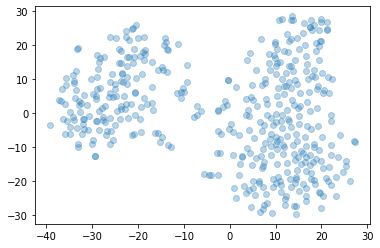

In [278]:
plot_embeddings(dimensions_2d,
                title="Nothing", 
                  colors=get_random_colors(10),
                  color_indices=[1,2,3,4,5,6,7,8,9,10])

## Combining context and Valence + Arousal Labelling

In [ ]:
combinations= {
    "happy": {"arousal": "high", "valence": "positive"},
    "relaxed": {"arousal": "low", "valence": "positive"},
    "sad": {"arousal": "low", "valence": "negative"},
    "angry": {"arousal": "high", "valence": "negative"},
}

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')